<a href="https://colab.research.google.com/github/PsorTheDoctor/learning-from-videos/blob/master/notebooks/cct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CCT: Compact Convolutional Transformer

In [1]:
!pip install -q keras --upgrade
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.1/999.1 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.1 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [projection_dim, projection_dim]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 10
image_size = 224

In [5]:
def load_data(path):
    x_train = np.load(path + 'train/images.npy')
    y_train = np.load(path + 'train/joints.npy')
    x_test = np.load(path + 'test/images.npy')
    y_test = np.load(path + 'test/joints.npy')
    return x_train, y_train, x_test, y_test

In [6]:
path = 'drive/MyDrive/learning-from-observation/data/snake/'
num_classes = 2
input_shape = (224, 224, 3)

x_train, y_train, x_test, y_test = load_data(path)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4000, 224, 224, 3) - y_train shape: (4000, 2)
x_test shape: (1000, 224, 224, 3) - y_test shape: (1000, 2)


In [7]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )
        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = keras.ops.reshape(
            outputs,
            (
                -1,
                keras.ops.shape(outputs)[1] * keras.ops.shape(outputs)[2],
                keras.ops.shape(outputs)[-1],
            ),
        )
        return reshaped

In [8]:
class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )
        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = keras.ops.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = keras.ops.convert_to_tensor(self.position_embeddings)
        position_embeddings = keras.ops.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return keras.ops.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape

In [9]:
class SequencePooling(layers.Layer):
    def __init__(self):
        super().__init__()
        self.attention = layers.Dense(1)

    def call(self, x):
        attention_weights = keras.ops.softmax(self.attention(x), axis=1)
        attention_weights = keras.ops.transpose(attention_weights, axes=(0, 2, 1))
        weighted_representation = keras.ops.matmul(attention_weights, x)
        return keras.ops.squeeze(weighted_representation, -2)

In [10]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (keras.ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + keras.random.uniform(
                shape, 0, 1, seed=self.seed_generator
            )
            random_tensor = keras.ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.ops.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential([
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ], name="data_augmentation",
)

In [22]:
def build_cct(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)
    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)
    # Apply positional embedding.
    if positional_emb:
        sequence_length = encoded_patches.shape[1]
        encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
            encoded_patches
        )
    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    weighted_representation = SequencePooling()(representation)

    logits = layers.Dense(num_classes)(weighted_representation)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

model = build_cct()
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ data_augmentation         │ (None, 224, 224, 3)    │          0 │ input_layer_3[0][0]        │
│ (Sequential)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ cct_tokenizer_1           │ (None, 3136, 128)      │     75,456 │ data_augmentation[1][0]    │
│ (CCTTokenizer)            │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ position_embedding_1      │ (None, 3136, 128)      │    401,408 │ cct_tokenizer_1[0][0]      │
│ (PositionEmbedding)       │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ add_5 (Add)               │ (None, 3136, 128)      │          0 │ cct_tokenizer_1[0][0],     │
│                           │                        │            │ position_embedding_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ layer_normalization_5     │ (None, 3136, 128)      │        256 │ add_5[0][0]                │
│ (LayerNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ multi_head_attention_2    │ (None, 3136, 128)      │    131,968 │ layer_normalization_5[0][… │
│ (MultiHeadAttention)      │                        │            │ layer_normalization_5[0][… │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ stochastic_depth_4        │ (None, 3136, 128)      │          0 │ multi_head_attention_2[0]… │
│ (StochasticDepth)         │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ add_6 (Add)               │ (None, 3136, 128)      │          0 │ stochastic_depth_4[0][0],  │
│                           │                        │            │ add_5[0][0]                │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ layer_normalization_6     │ (None, 3136, 128)      │        256 │ add_6[0][0]                │
│ (LayerNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_6 (Dense)           │ (None, 3136, 128)      │     16,512 │ layer_normalization_6[0][… │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 3136, 128)      │          0 │ dense_6[0][0]              │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_7 (Dense)           │ (None, 3136, 128)      │     16,512 │ dropout_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 3136, 128)      │          0 │ dense_7[0][0]              │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ stochastic_depth_5   

 Total params: 808,773 (3.09 MB)

 Trainable params: 808,773 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

##Snake

In [14]:
def train():
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.Huber(),
        metrics=[
            keras.metrics.MeanSquaredError(),
            keras.metrics.MeanAbsoluteError()
        ]
    )
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test)
    )
    return history

history_snake = train()

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 785ms/step - loss: 0.3514 - mean_absolute_error: 0.6989 - mean_squared_error: 1.0925 - val_loss: 0.1612 - val_mean_absolute_error: 0.4834 - val_mean_squared_error: 0.3219
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 198s 792ms/step - loss: 0.1803 - mean_absolute_error: 0.5136 - mean_squared_error: 0.3623 - val_loss: 0.1776 - val_mean_absolute_error: 0.5051 - val_mean_squared_error: 0.3552
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 203s 797ms/step - loss: 0.1760 - mean_absolute_error: 0.5096 - mean_squared_error: 0.3526 - val_loss: 0.1715 - val_mean_absolute_error: 0.4966 - val_mean_squared_error: 0.3431
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 198s 791ms/step - loss: 0.1764 - mean_absolute_error: 0.5113 - mean_squared_error: 0.3533 - val_loss: 0.1605 - val_mean_absolute_error: 0.4831 - val_mean_squared_error: 0.3205
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 198s 791ms/step - loss: 0.1699 - mean_absolute_error: 0.5022 - mean_squared_error: 0.3401 - val_

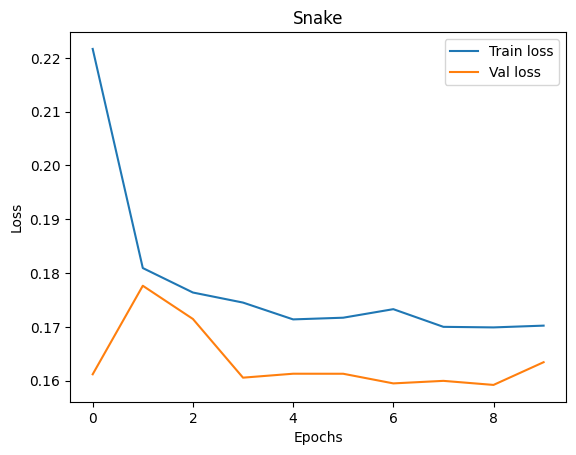

In [17]:
plt.plot(history_snake.history['loss'], label='Train loss')
plt.plot(history_snake.history['val_loss'], label='Val loss')
plt.title('Snake')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [18]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
np.save('cct_snake_train.npy', y_pred_train)
np.save('cct_snake_test.npy', y_pred_test)

pred = pd.concat([
    pd.DataFrame(np.squeeze(y_pred_test), columns=['Pred joint 1', 'Pred joint 2']),
    pd.DataFrame(np.squeeze(y_test), columns=['True joint 1', 'True joint 2']),
    pd.DataFrame(np.squeeze(np.abs(y_test - y_pred_test)), columns=['Error joint 1', 'Error joint 2'])
], axis=1)
pred.head()

125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 441ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 429ms/step


,Pred joint 1,Pred joint 2,True joint 1,True joint 2,Error joint 1,Error joint 2
0,0.141721,0.082703,-0.410268,-0.136914,0.551988,0.219617
1,0.139532,0.083022,-0.259984,-0.577953,0.399516,0.660975
2,0.131924,0.083578,-0.903939,-0.463761,1.035863,0.547339
3,0.135613,0.082336,0.352720,0.659732,0.217107,0.577396
4,0.141695,0.081428,0.758945,0.801495,0.617250,0.720067


In [19]:
mean_train = np.mean(np.abs(y_train - y_pred_train))
std_train = np.std(np.abs(y_train - y_pred_train))
mean_test = np.mean(np.abs(y_test - y_pred_test))
std_test = np.std(np.abs(y_test - y_pred_test))

print('Train mean:', mean_train)
print('Train std dev:', std_train)
print('Test mean:', mean_test)
print('Test std dev:', std_test)

Train mean: 0.5064937
Train std dev: 0.2982266
Test mean: 0.48598614
Test std dev: 0.30071613


##Turtle

In [21]:
path = 'drive/MyDrive/learning-from-observation/data/turtle/'
num_classes = 4
input_shape = (224, 224, 3)

x_train, y_train, x_test, y_test = load_data(path)

# Remove fixed joints
y_train = y_train[:, :4]
y_test = y_test[:, :4]

In [23]:
def train():
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.Huber(),
        metrics=[
            keras.metrics.MeanSquaredError(),
            keras.metrics.MeanAbsoluteError()
        ]
    )
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test)
    )
    return history

history_turtle = train()

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 802ms/step - loss: 0.1339 - mean_absolute_error: 0.2930 - mean_squared_error: 0.4248 - val_loss: 0.0044 - val_mean_absolute_error: 0.0795 - val_mean_squared_error: 0.0088
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 199s 792ms/step - loss: 0.0047 - mean_absolute_error: 0.0810 - mean_squared_error: 0.0093 - val_loss: 0.0042 - val_mean_absolute_error: 0.0780 - val_mean_squared_error: 0.0084
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 196s 767ms/step - loss: 0.0048 - mean_absolute_error: 0.0825 - mean_squared_error: 0.0097 - val_loss: 0.0048 - val_mean_absolute_error: 0.0826 - val_mean_squared_error: 0.0097
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 202s 766ms/step - loss: 0.0052 - mean_absolute_error: 0.0845 - mean_squared_error: 0.0103 - val_loss: 0.0060 - val_mean_absolute_error: 0.0900 - val_mean_squared_error: 0.0121
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 191s 765ms/step - loss: 0.0047 - mean_absolute_error: 0.0815 - mean_squared_error: 0.0094 - val_

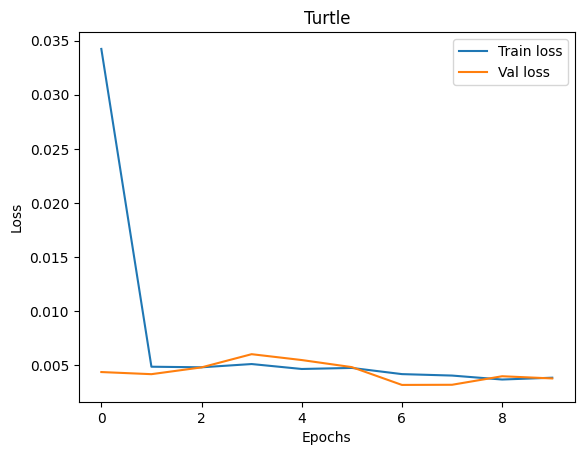

In [24]:
plt.plot(history_turtle.history['loss'], label='Train loss')
plt.plot(history_turtle.history['val_loss'], label='Val loss')
plt.title('Turtle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [25]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
np.save('cct_turtle_train.npy', y_pred_train)
np.save('cct_turtle_test.npy', y_pred_test)

pred = pd.concat([pd.DataFrame(np.squeeze(y_pred_test),
                               columns=['pred_joint_1', 'pred_joint_2', 'pred_joint_3', 'pred_joint_4']),
                  pd.DataFrame(np.squeeze(y_test),
                               columns=['true_joint_1', 'true_joint_2', 'true_joint_3', 'true_joint_4']),
                  pd.DataFrame(np.squeeze(np.abs(y_pred_test - y_test)),
                               columns=['error_joint_1', 'error_joint_2', 'error_joint_1', 'error_joint_2'])], axis=1)
pred.head()

125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step


,pred_joint_1,pred_joint_2,pred_joint_3,pred_joint_4,true_joint_1,true_joint_2,true_joint_3,true_joint_4,error_joint_1,error_joint_2,error_joint_1,error_joint_2
0,-0.069832,-0.019680,0.013569,-0.035537,-0.128912,0.063481,-0.024002,0.083393,0.059080,0.083161,0.037572,0.118930
1,-0.077315,-0.023270,-0.132235,-0.030641,0.007399,-0.139197,-0.146653,0.138487,0.084714,0.115927,0.014418,0.169127
2,-0.070963,-0.021987,-0.017584,-0.052676,-0.108892,0.149710,-0.045882,-0.028994,0.037929,0.171698,0.028298,0.023682
3,-0.067597,-0.019241,0.068962,-0.032000,0.085561,0.029545,0.039559,-0.088738,0.153158,0.048786,0.029403,0.056738
4,-0.074202,-0.021036,-0.088566,-0.031441,-0.108116,0.058700,-0.065223,0.148758,0.033914,0.079736,0.023343,0.180199


In [26]:
mean_train = np.mean(np.abs(y_train - y_pred_train))
std_train = np.std(np.abs(y_train - y_pred_train))
mean_test = np.mean(np.abs(y_test - y_pred_test))
std_test = np.std(np.abs(y_test - y_pred_test))

print('Train mean:', mean_train)
print('Train std dev:', std_train)
print('Test mean:', mean_test)
print('Test std dev:', std_test)

Train mean: 0.06796712
Train std dev: 0.05280268
Test mean: 0.06968814
Test std dev: 0.052543808
